[View in Colaboratory](https://colab.research.google.com/github/stanimman/Pneumonia-Detection/blob/master/Hello,_Colaboratory.ipynb)

<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

<h1>Welcome to Colaboratory!</h1>
Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. See our [FAQ](https://research.google.com/colaboratory/faq.html) for more info.

## Getting Started
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Loading and saving data: Local files, Drive, Sheets, Google Cloud Storage](/notebooks/io.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Using Google Cloud BigQuery](/notebooks/bigquery.ipynb)
- [Forms](/notebooks/forms.ipynb), [Charts](/notebooks/charts.ipynb), [Markdown](/notebooks/markdown_guide.ipynb), & [Widgets](/notebooks/widgets.ipynb)
- [TensorFlow with GPU](/notebooks/gpu.ipynb)
- [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/): [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb) & [First Steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)


## Highlighted Features
### Seedbank

Looking for Colab notebooks to learn from? Check out [Seedbank](https://tools.google.com/seedbank/), a place to discover interactive machine learning examples.

### TensorFlow execution

Colaboratory allows you to execute TensorFlow code in your browser with a single click. The example below adds two matrices.

$\begin{bmatrix}
  1. & 1. & 1. \\
  1. & 1. & 1. \\
\end{bmatrix} +
\begin{bmatrix}
  1. & 2. & 3. \\
  4. & 5. & 6. \\
\end{bmatrix} =
\begin{bmatrix}
  2. & 3. & 4. \\
  5. & 6. & 7. \\
\end{bmatrix}$

In [2]:
!pip uninstall Pillow -y

!pip install Pillow 

Uninstalling Pillow-4.0.0:
  Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 9.5MB/s 


In [0]:
# install dependencies not included by Colab# insta 
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug

In [0]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [12]:
import PIL
print(PIL.PILLOW_VERSION)

5.2.0


In [4]:
import imgaug as ia
from imgaug import augmenters as iaa
ia.seed(1)
image = ia.quokka(size=(256, 256))
bbs = ia.BoundingBoxesOnImage([
ia.BoundingBox(x1=65, y1=100, x2=200, y2=150),
ia.BoundingBox(x1=150, y1=80, x2=200, y2=130)
], shape=image.shape)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [0]:
# Rescale image and bounding boxes
image_rescaled = ia.imresize_single_image(image, (512, 512))
bbs_rescaled = bbs.on(image_rescaled)
# Draw image before/after rescaling and with rescaled bounding boxes
image_bbs = bbs.draw_on_image(image, thickness=2)
image_rescaled_bbs = bbs_rescaled.draw_on_image(image_rescaled, thickness=2)


In [11]:
print(image.shape , image_rescaled_bbs.shape)
print(bbs,bbs_rescaled)

(256, 256, 3) (512, 512, 3)
BoundingBoxesOnImage([BoundingBox(x1=65.0000, y1=100.0000, x2=200.0000, y2=150.0000, label=None), BoundingBox(x1=150.0000, y1=80.0000, x2=200.0000, y2=130.0000, label=None)], shape=(256, 256, 3)) BoundingBoxesOnImage([BoundingBox(x1=130.0000, y1=200.0000, x2=400.0000, y2=300.0000, label=None), BoundingBox(x1=300.0000, y1=160.0000, x2=400.0000, y2=260.0000, label=None)], shape=(512, 512, 3))


In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath('./lesson3-data')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [19]:
!pip install kaggle-cli
!kg download -u 'stanimman' -p '***' -c 'rsna-pneumonia-detection-challenge'

    100% |████████████████████████████████| 81kB 4.3MB/s 
    100% |████████████████████████████████| 5.3MB 4.8MB/s 
    100% |████████████████████████████████| 102kB 25.6MB/s 
    100% |████████████████████████████████| 81kB 25.2MB/s 
  Running setup.py bdist_wheel for kaggle-cli ... - done
  Stored in directory: /root/.cache/pip/wheels/d5/bb/10/c1dd1b08c7433c943cb55c46367ae3f891415e8a37300ff8a7
  Running setup.py bdist_wheel for cliff ... - \ done
  Stored in directory: /root/.cache/pip/wheels/02/22/09/66f8c243f9c68dee7e6456a0fd6c117439a64394fdaf02d965
  Running setup.py bdist_wheel for configparser ... - done
  Stored in directory: /root/.cache/pip/wheels/a3/61/79/424ef897a2f3b14684a7de5d89e8600b460b89663e6ce9d17c
  Running setup.py bdist_wheel for PrettyTable ... - done
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Running setup.py bdist_wheel for pyperclip ... - done
  Stored in directory: /root/.cache/pip/

In [37]:
!rm stage_1_detailed_class_info.csv
!rm stage_1_sample_submission.csv
!rm stage_1_train_labels.csv.1

rm: cannot remove 'stage_1_detailed_class_info.csv': No such file or directory
rm: cannot remove 'stage_1_sample_submission.csv': No such file or directory


### GitHub

You can save a copy of your Colab notebook to Github by using File > Save a copy to GitHub…

You can load any .ipynb on GitHub by just adding the path to colab.research.google.com/github/ . For example, [colab.research.google.com/github/tensorflow/models/blob/master/samples/core/get_started/_index.ipynb](https://colab.research.google.com/github/tensorflow/models/blob/master/samples/core/get_started/_index.ipynb) will load [this .ipynb](https://github.com/tensorflow/models/blob/master/samples/core/get_started/_index.ipynb) on GitHub.



In [39]:
!git clone https://github.com/stanimman/Pneumonia-Detection.git

Cloning into 'Pneumonia-Detection'...
remote: Counting objects: 28, done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 28 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [0]:
!unzip -q -o stage_1_train_images.zip -d stage_1_train_images # Need to understand what is the various arg

In [50]:
ds1 = pydicom.dcmread("stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm")
pixel_bytes  = ds1.PixelData
pix = ds1.pixel_array
print(pix.shape)
print(pix)

(1024, 1024)
[[0 1 2 ... 2 2 2]
 [0 1 2 ... 2 2 2]
 [0 1 2 ... 3 3 3]
 ...
 [1 3 4 ... 7 7 7]
 [0 2 3 ... 5 5 5]
 [0 0 1 ... 0 0 0]]


In [43]:
!ls

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  wget-log
Pneumonia-Detection			       wget-log.1
stage_1_test_images.zip			       wget-log.2
stage_1_train_images			       wget-log.3
stage_1_train_images.zip		       wget-log.4


In [46]:
import PIL
print(PIL.PILLOW_VERSION)
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import pil_loader
from torchvision import transforms, utils
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from torchvision import  models
import torch.nn as nn
import torch.optim as optim
import copy
from torch.optim import lr_scheduler
import time
import datetime as dt
from PIL import Image
import cv2

5.2.0
tcmalloc: large alloc 1073750016 bytes == 0x5af84000 @  0x7f8216ca41c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
0.4.0
True


In [0]:
stage_1_train_labels_df = pd.read_csv('Pneumonia-Detection/stage_1_train_labels.csv')

In [49]:
stage_1_train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

In [53]:
bb = [264,152,213,379]
frm_bb = hw_bb(bb)
print(frm_bb)

[152 264 530 476]


In [0]:
from matplotlib import patches, patheffects
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [0]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [0]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

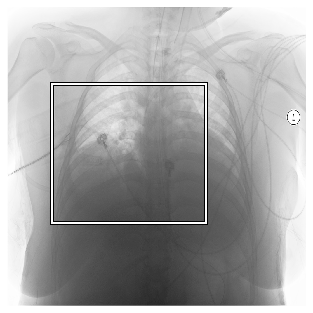

In [62]:
ax = show_img(pix)
b = frm_bb
draw_rect(ax, b)

In [0]:
transform=transforms.Compose([transforms.ToPILImage(),transforms.Resize(224)])
image = np.stack((pix,)*3,-1)
tr_im = transform(image)

In [71]:
trm_bb = [i * (224/1024) for i in frm_bb]
print(trm_bb)

[33.25, 57.75, 115.9375, 104.125]


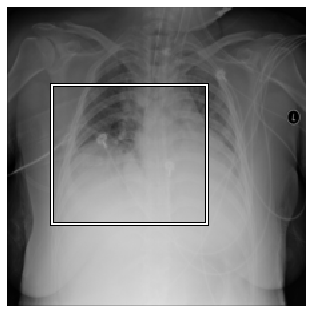

In [84]:
ax = show_img(tr_im)
b = trm_bb
draw_rect(ax,b)

In [0]:
stage_1_train_labels_df = stage_1_train_labels_df.fillna(0)

In [0]:
stage_1_train_labels_df['path'] = stage_1_train_labels_df['patientId']+'.dcm'

In [89]:
stage_1_train_labels_df.head()

,patientId,x,y,width,height,Target,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,00322d4d-1c29-4943-afc9-b6754be640eb.dcm
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,00436515-870c-4b36-a041-de91049b9ab4.dcm


In [0]:
random_number_list = random.sample(range(0, 28988), 5000)

In [91]:
stage_1_test_labels_df = stage_1_train_labels_df.iloc[random_number_list,:]
stage_1_test_labels_df.Target.value_counts()

0    3445
1    1555
Name: Target, dtype: int64

In [92]:
Pnumenoia_Case = stage_1_train_labels_df[stage_1_train_labels_df.Target == 1]
Non_Pnumenoia_Case = stage_1_train_labels_df[stage_1_train_labels_df.Target == 0]
stage_1_train_labels_dfstage_1  = pd.concat([Pnumenoia_Case,(Non_Pnumenoia_Case.iloc[range(10000),:])])
stage_1_train_labels_df.Target.value_counts()

0    20025
1     8964
Name: Target, dtype: int64

In [0]:
class RSNADataset(Dataset):
    """Mura dataset."""
    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (dataframe): Path to the image file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 6])
        
        # Reading Pydicom Files 
        ds = pydicom.dcmread(img_name)
        image = ds.pixel_array
        image = np.stack((image,)*3,-1)
        labels = self.df.iloc[idx, 5]
        labels = labels.astype('float')
        bb = self.df.iloc[idx, 1:5].tolist()
        #bb = np.array(bb)
        #print(bb)
        bb = torch.FloatTensor(bb)
        #bb = torch.from_numpy(bb)
        print(bb) 
        if self.transform:
            image = self.transform(image)
        return [image, labels,bb]

In [0]:
transformed_train_dataset = RSNADataset(df=stage_1_train_labels_df,
                                    root_dir='stage_1_train_images',
                                    transform=transforms.Compose([
                                               transforms.ToPILImage(),
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               
                                           ]))

transformed_valid_dataset = RSNADataset(df=stage_1_test_labels_df,
                                     root_dir='stage_1_train_images',
                                     transform=transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               
                                            ]))

In [0]:
transformed_train_dl  = DataLoader(transformed_train_dataset,batch_size=8,shuffle=True)
transformed_valid_dl = DataLoader(transformed_valid_dataset,batch_size=8,shuffle=True)

In [156]:
image1,label1,bb1 = next(iter(transformed_train_dl))

tensor([ 616.,  690.,  168.,  180.])
tensor([ 124.,  442.,  235.,  380.])
tensor([ 264.,  350.,  197.,  437.])
tensor([ 0.,  0.,  0.,  0.])
tensor([ 0.,  0.,  0.,  0.])
tensor([ 580.,  163.,  269.,  433.])
tensor([ 0.,  0.,  0.,  0.])
tensor([ 197.,  358.,  259.,  333.])


In [159]:
print(bb1)
print(bb1.shape)

tensor([[ 616.,  690.,  168.,  180.],
        [ 124.,  442.,  235.,  380.],
        [ 264.,  350.,  197.,  437.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [ 580.,  163.,  269.,  433.],
        [   0.,    0.,    0.,    0.],
        [ 197.,  358.,  259.,  333.]])
torch.Size([8, 4])


In [158]:
label1

tensor([ 1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.], dtype=torch.float64)

In [120]:
image1.shape

torch.Size([8, 3, 224, 224])

### Visualization

Colaboratory includes widely used libraries like [matplotlib](https://matplotlib.org/), simplifying visualization.

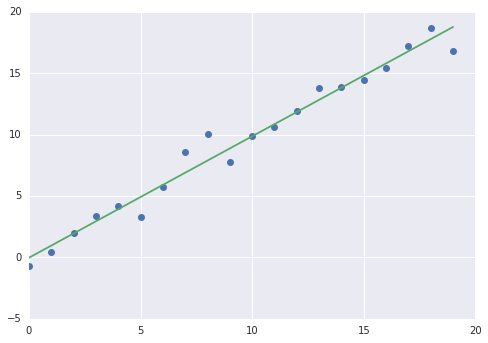

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(20)
y = [x_i + np.random.randn(1) for x_i in x]
a, b = np.polyfit(x, y, 1)
_ = plt.plot(x, y, 'o', np.arange(20), a*np.arange(20)+b, '-')

Want to use a new library?  `pip install` it at the top of the notebook. Then that library can be used anywhere else in the notebook. For recipes to import commonly used libraries, refer to the [importing libraries example notebook](/notebooks/snippets/importing_libraries.ipynb).

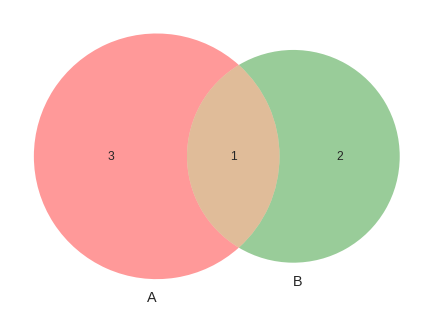

In [0]:
!pip install -q matplotlib-venn

from matplotlib_venn import venn2
_ = venn2(subsets = (3, 2, 1))

### Forms

Forms can be used to parameterize code. See the [forms example notebook](/notebooks/forms.ipynb) for more details.

In [0]:
#@title Examples

text = 'value' #@param 
date_input = '2018-03-22' #@param {type:"date"}
number_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}
dropdown = '1st option' #@param ["1st option", "2nd option", "3rd option"]


### Local runtime support

Colab  supports connecting to a Jupyter runtime on your local machine. For more information, see our [documentation](https://research.google.com/colaboratory/local-runtimes.html).